In [13]:
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from IPython.display import SVG
from krxns.cheminfo import draw_molecule

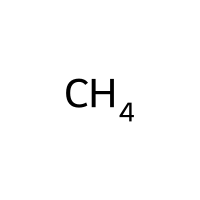

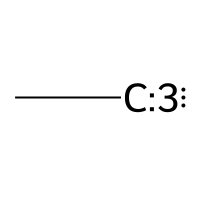

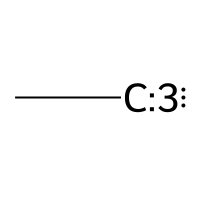

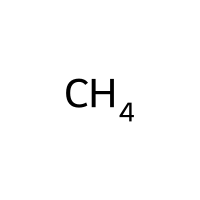

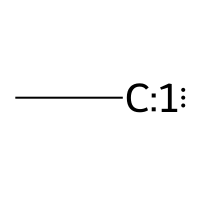

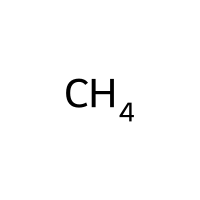

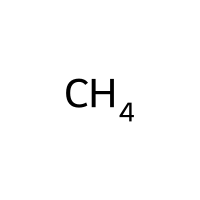

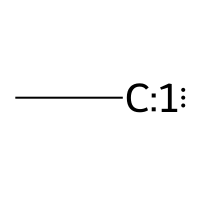

In [14]:
rxn = AllChem.ReactionFromSmarts("[#6:1]-[#6:2]>>[#6:1].[#6:2]")
rct = '[#6:1]-[#6:2]-[#6:3]'
pdt = '[#6:1]-[#6:2].[#6:3]'
outputs = rxn.RunReactants((Chem.MolFromSmiles(rct),))

for out in outputs:
    for elt in out:
        display(SVG(draw_molecule(elt)))

In [15]:
for atom in elt.GetAtoms():
    print(atom.GetAtomMapNum())

0
1


Atoms which are just copied over directly from the reactants (those which were not mapped in the reaction) will still have the reactant_idx property set.
The reacting atoms will have the old_mapno property set, and you can lookup which reactant those came from in the atomMapToReactantMap dictionary.

In [17]:
rxn = Chem.rdChemReactions.ReactionFromSmarts('[C:1]-[O:2].[C:3](=[O:4])[OH]>>[C:1]-[O:2]-[C:3]=[O:4]')
reactants = [Chem.MolFromSmiles(x) for x in ('CCO','OC=O')]
for i,m in enumerate(reactants):
    for atom in m.GetAtoms():
        atom.SetIntProp('reactant_idx',i)

ps = rxn.RunReactants(reactants)
p0 = ps[0][0]
for atom in p0.GetAtoms():
    print(atom.GetIdx(),atom.GetPropsAsDict())

# {'old_mapno': 1, 'react_atom_idx': 1}
# {'_ReactionDegreeChanged': 1, 'old_mapno': 2, 'react_atom_idx': 2}
# {'old_mapno': 3, 'react_atom_idx': 1}
# {'old_mapno': 4, 'react_atom_idx': 2}
# {'__computedProps': <rdkit.rdBase._vectNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE object at 0x7f9ac5161270>, '_CIPRank': 0, 'reactant_idx': 0, 'react_atom_idx': 0}
atomMapToReactantMap={}
for ri in range(rxn.GetNumReactantTemplates()):
    rt = rxn.GetReactantTemplate(ri)
    for atom in rt.GetAtoms():
        if atom.GetAtomMapNum():
            atomMapToReactantMap[atom.GetAtomMapNum()] = ri


atomMapToReactantMap
# {1: 0, 2: 0, 3: 1, 4: 1}

0 {'old_mapno': 1, 'react_atom_idx': 1}
1 {'_ReactionDegreeChanged': 1, 'old_mapno': 2, 'react_atom_idx': 2}
2 {'old_mapno': 3, 'react_atom_idx': 1}
3 {'old_mapno': 4, 'react_atom_idx': 2}
4 {'__computedProps': <rdkit.rdBase._vectSs object at 0x7f8cc6a85ac0>, '_CIPRank': 0, 'reactant_idx': 0, 'react_atom_idx': 0}


{1: 0, 2: 0, 3: 1, 4: 1}